In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import hashlib
import pandas as pd

# Для відображення графіків безпосередньо в ноутбуці
%matplotlib inline

In [28]:
data_dir = "chest_xray"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "val")

In [29]:
def count_images(folder):
    normal = len(os.listdir(os.path.join(folder, "NORMAL")))
    pneumonia = len(os.listdir(os.path.join(folder, "PNEUMONIA")))
    return normal, pneumonia

train_normal, train_pneumonia = count_images(train_dir)
test_normal, test_pneumonia = count_images(test_dir)
val_normal, val_pneumonia = count_images(val_dir)

print(f"Train: Normal={train_normal}, Pneumonia={train_pneumonia}")
print(f"Test: Normal={test_normal}, Pneumonia={test_pneumonia}")
print(f"Val: Normal={val_normal}, Pneumonia={val_pneumonia}")

Train: Normal=1340, Pneumonia=3850
Test: Normal=234, Pneumonia=390
Val: Normal=8, Pneumonia=8


Виводить статистику, яка показує дисбаланс у тренувальному наборі (значно більше зображень із пневмонією)

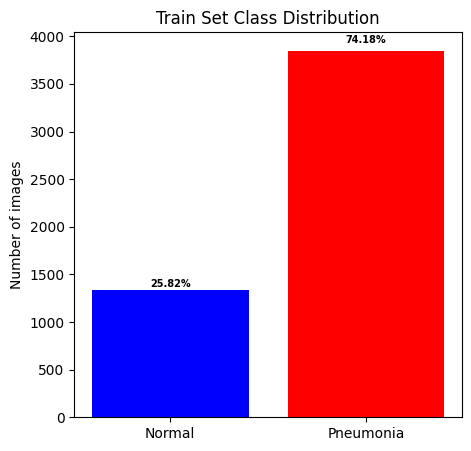

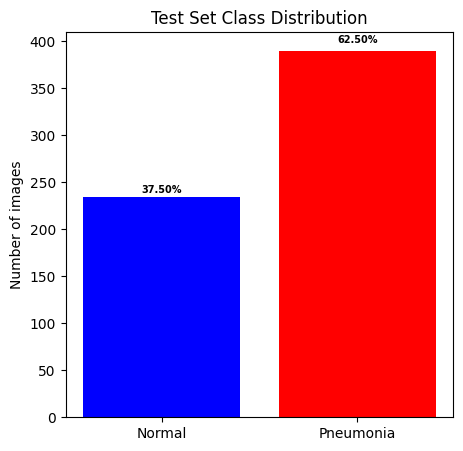

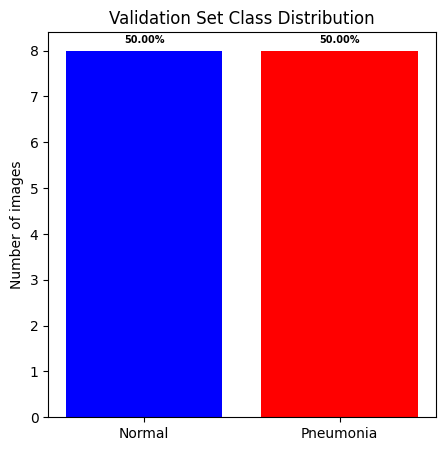

In [47]:
def plot_class_distribution(normal, pneumonia, dataset_name):
    labels = ['Normal', 'Pneumonia']
    counts = [normal, pneumonia]
    total = normal + pneumonia
    percentages = [f"{(c/total)*100:.2f}%" for c in counts]
    
    plt.figure(figsize=(5, 5))
    bars = plt.bar(labels, counts, color=['blue', 'red'])
    
    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height*1.02, percentage, 
                 ha='center', fontsize=7, fontweight='bold')
    
    plt.title(f"{dataset_name} Set Class Distribution")
    plt.ylabel("Number of images")
    plt.show()

plot_class_distribution(train_normal, train_pneumonia, "Train")
plot_class_distribution(test_normal, test_pneumonia, "Test")
plot_class_distribution(val_normal, val_pneumonia, "Validation")

Будує стовпчасті діаграми для кожного набору (`train`, `test`, `val`).

Показує значний дисбаланс класів у тренувальному наборі

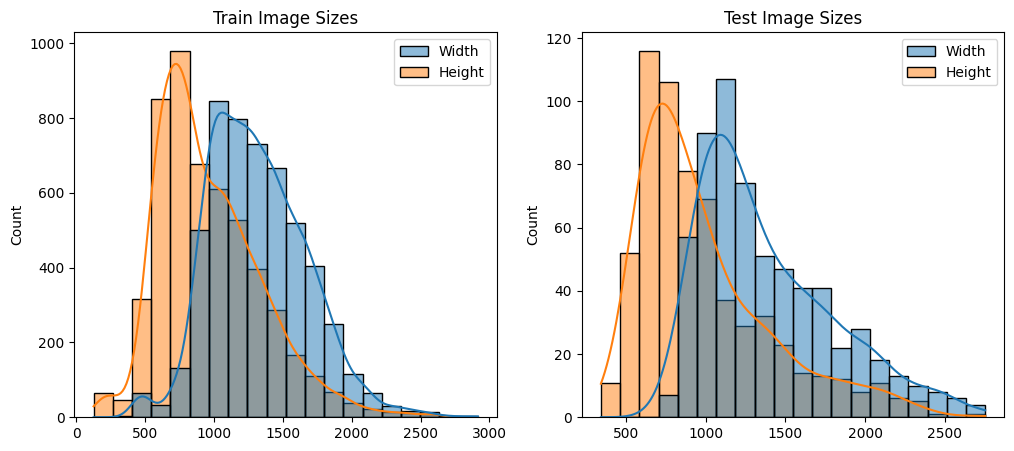

In [48]:
def analyze_image_sizes(folder):
    sizes = []
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(folder, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            with Image.open(img_path) as img:
                sizes.append(img.size)
    return sizes

train_sizes = analyze_image_sizes(train_dir)
test_sizes = analyze_image_sizes(test_dir)

train_sizes_df = pd.DataFrame(train_sizes, columns=['Width', 'Height'])
test_sizes_df = pd.DataFrame(test_sizes, columns=['Width', 'Height'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_sizes_df, bins=20, kde=True)
plt.title("Train Image Sizes")

plt.subplot(1, 2, 2)
sns.histplot(test_sizes_df, bins=20, kde=True)
plt.title("Test Image Sizes")
plt.show()

Розміри зображень різні, тому Resize до 224x224 у трансформаціях є критично важливим.

In [32]:
def find_duplicates(folder):
    hashes = {}
    duplicates = []
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(folder, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            with open(img_path, 'rb') as f:
                img_hash = hashlib.md5(f.read()).hexdigest()
            if img_hash in hashes:
                duplicates.append((img_path, hashes[img_hash]))
            else:
                hashes[img_hash] = img_path
    return duplicates

train_duplicates = find_duplicates(train_dir)
print("Дублікати у тренувальному наборі:", len(train_duplicates))

Дублікати у тренувальному наборі: 0


In [33]:
def remove_duplicates(folder):
    hashes = {}
    duplicates = []
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(folder, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            with open(img_path, 'rb') as f:
                img_hash = hashlib.md5(f.read()).hexdigest()
            if img_hash in hashes:
                duplicates.append(img_path)
            else:
                hashes[img_hash] = img_path
                
    # Видалити дублікати
    for dup_path in duplicates:
        os.remove(dup_path)
    print(f"Видалено {len(duplicates)} дублікатів")

# Викликати для тренувальної папки
remove_duplicates(train_dir)

Видалено 0 дублікатів


In [34]:
train_duplicates = find_duplicates(train_dir)
print("Дублікати у тренувальному наборі:", len(train_duplicates))

Дублікати у тренувальному наборі: 0


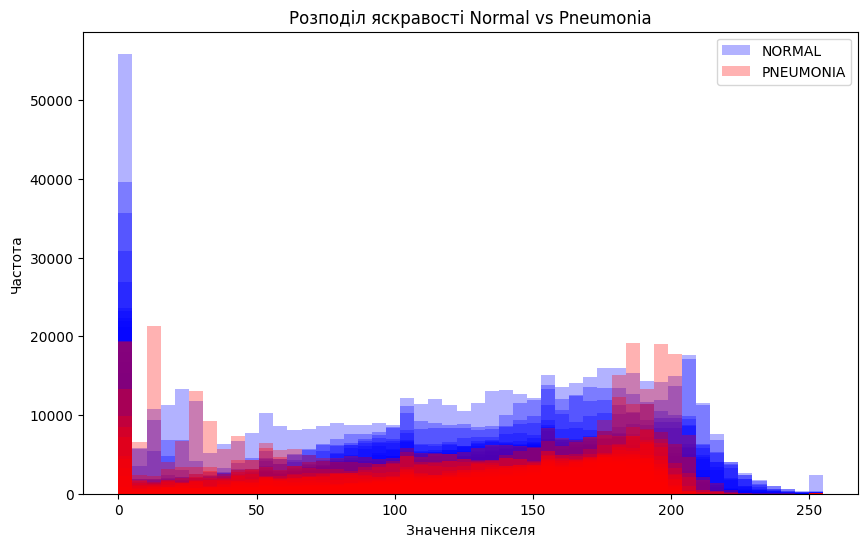

In [51]:
def compare_pixel_distributions(folder, num_samples=20):
    plt.figure(figsize=(10, 6))
    
    added_labels = {"NORMAL": False, "PNEUMONIA": False}  
    
    for class_name, color in zip(['NORMAL', 'PNEUMONIA'], ['blue', 'red']):
        class_dir = os.path.join(folder, class_name)
        for img_name in os.listdir(class_dir)[:num_samples]:
            img_path = os.path.join(class_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    img_gray = img.convert('L')
                    img_array = np.array(img_gray).flatten()
                    sampled_pixels = np.random.choice(img_array, 
                                                      size=int(len(img_array) * 0.1), 
                                                      replace=False)
                    
                    
                    label = class_name if not added_labels[class_name] else None
                    plt.hist(sampled_pixels, bins=50, alpha=0.3, color=color, label=label)
                    
                    added_labels[class_name] = True 
            except Exception as e:
                print(f"Помилка обробки {img_path}: {str(e)}")
    
    plt.title("Розподіл яскравості Normal vs Pneumonia")
    plt.xlabel("Значення пікселя")
    plt.ylabel("Частота")
    plt.legend() 
    plt.show()

compare_pixel_distributions(train_dir)


Показує, що зображення з пневмонією мають іншу яскравість.

Вказує на можливу важливість контрасту та інтенсивності пікселів у класифікації

In [36]:
# Для тренувальних даних: аугментація + нормалізація
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Зміна розміру для ResNet
    transforms.RandomRotation(20),    # Випадкове обертання
    transforms.RandomHorizontalFlip(), # Випадкове віддзеркалення
    transforms.ToTensor(),           # Конвертація в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормалізація для ImageNet
])

# Для тесту/валідації: тільки нормалізація
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [37]:
# Тренувальний датасет
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
# Тестовий датасет
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
# Валідаційний датасет
val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)

# Класи (NORMAL=0, PNEUMONIA=1)
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


In [38]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [39]:
# Отримати один батч даних
images, labels = next(iter(train_loader))
print("Розмір тензора зображень:", images.shape)  # [batch_size, channels, height, width]
print("Розмір тензора міток:", labels.shape)

Розмір тензора зображень: torch.Size([32, 3, 224, 224])
Розмір тензора міток: torch.Size([32])


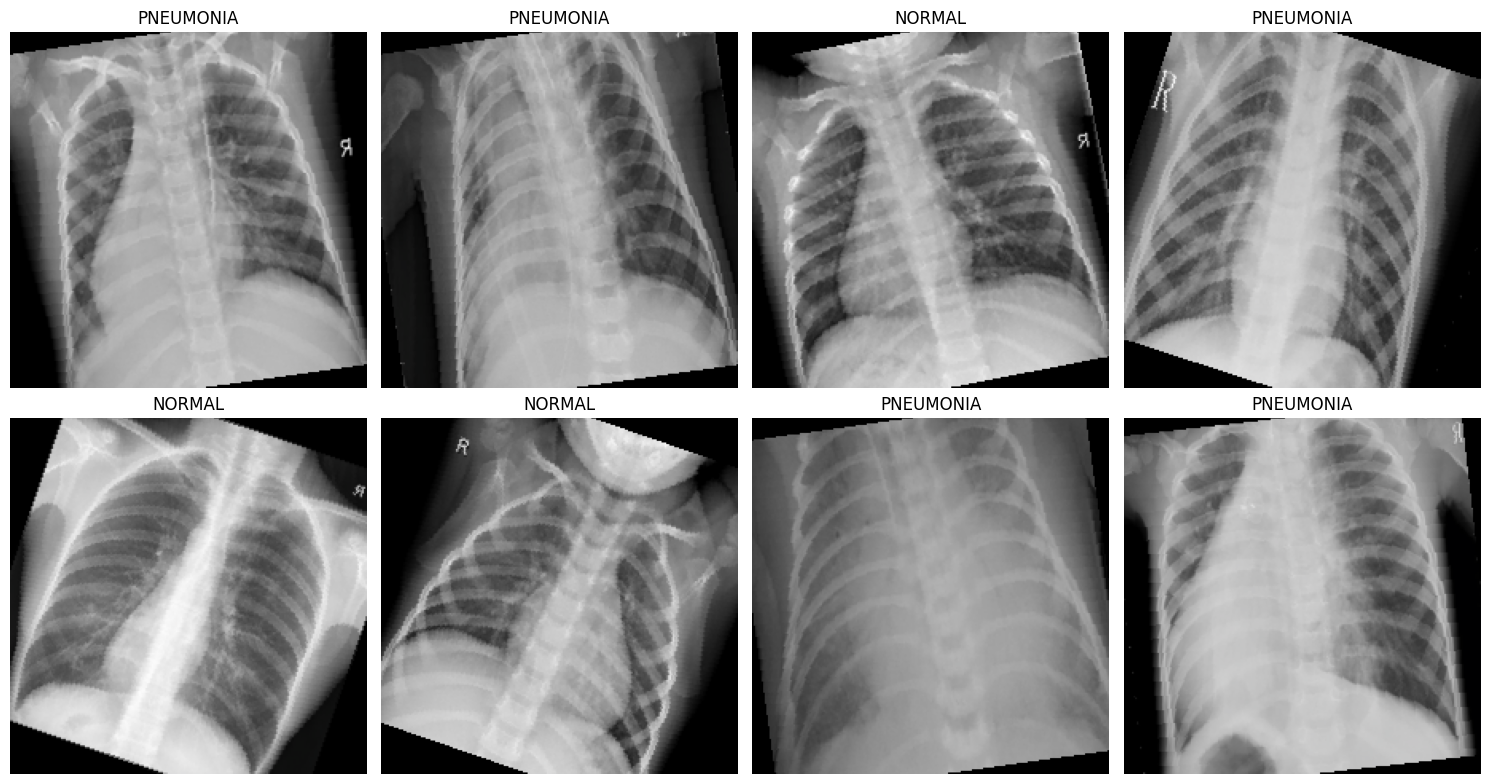

In [40]:
def imshow(img_tensor, ax, title=None):
    img = img_tensor.clone().detach().cpu().numpy()
    img = img.transpose((1, 2, 0))  

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img * std) + mean  
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.axis('off')
    if title:
        ax.set_title(title)

# Візуалізація 8 випадкових зображень
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(len(train_dataset))
    image, label = train_dataset[idx]
    imshow(image, ax, title=class_names[label])  # Передаємо поточну вісь `ax`
plt.tight_layout()
plt.show()